In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az
np.random.seed(42)

# Visualization 

Data visualization is a very broad area with graphical representations targeting very particular audiences like a scientific paper in some not-over-hyped subject to newspapers with million readers. We will focus on scientific visualizations and in particular visualizations useful in a Bayesian setting.

As humans are generally good at visualizing data, data visualization is both a powerful tool for analyzing data and models and is also a powerful tool to convey information to our target audience. Using words, tables and single numbers are generally less effective ways to communicate information. At the same time our visual system can be fooled, as you may have experience with visual illusions, the reason is that our visual system is tuned to process information in useful ways and this generally means interpreting the information, that is our brains _guess stuff_ and not just _reproduce the outside world_. Effective data visualization requires that we recognize the abilities and limitations of our own visual system.

## Plot elements

To convey visual information we generally use shapes, including lines, circles, squares etc. These elements have properties associated to them like, position, shape and color.

ArviZ is build on top of matplotlib, thus is a good idea to get familiar with the names of the elements that are used by matplotlib to create a plot.

![]()

<a href="https://matplotlib.org/3.1.1/gallery/showcase/anatomy.html"><img src="https://matplotlib.org/_images/anatomy.png"></a>

## Colors

Matplotlib allows easy-to-switch plotting "styles" by defining  style sheets. ArviZ is packed with a few additional styles that can be applied globally by writing `az.style.use(nameofstyle)` or locally using a `with` statement like in the following example:

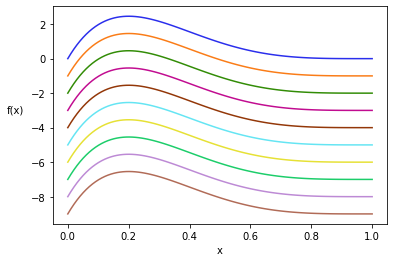

In [2]:
x = np.linspace(0, 1, 100)
dist = stats.beta(2, 5).pdf(x)

fig = plt.figure()
with az.style.context('arviz-colors'):
    for i in range(10):
        plt.plot(x, dist - i, f'C{i}', label=f'C{i}')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0, labelpad=15);

`az.style` is just and alias of `matplotlib.pyplot.style`, so everything you can do with one of them you can do with the other. 

All styles included with ArviZ use the same color-blind friendly palette. This palette was designed using https://colorcyclepicker.mpetroff.net/. If you need to do plots in grey-scale we recommend to restrict yourself to the first 3 colors of the arviz default palette ('C0', 'C1' and 'C2'), otherwise you may need to use different [lines styles](https://matplotlib.org/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle) or [different markers](https://matplotlib.org/api/markers_api.html#module-matplotlib.markers)

In [3]:
from matplotlib import lines
print(lines.lineStyles) 

{'-': '_draw_solid', '--': '_draw_dashed', '-.': '_draw_dash_dot', ':': '_draw_dotted', 'None': '_draw_nothing', ' ': '_draw_nothing', '': '_draw_nothing'}


In [4]:
from matplotlib import markers
print(markers.MarkerStyle.markers)

{'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', ' ': 'nothing', '': 'nothing'}


## Continuous and discrete distributions

A discrete distribution represents variables which can only take a countable number of values. Some examples of discrete random variables are number of coins in your pocket, spots on a giraffe, red cars in a city, people with flu etc. As we generally use integers to represent discrete variables, when ArviZ receives integers it will use [histograms](https://en.wikipedia.org/wiki/Histogram) to represent them. ArviZ always tries to associate the binned data with discrete values. For example in the following plot each _bar_ is associated with a integer in the interval [0, 9].

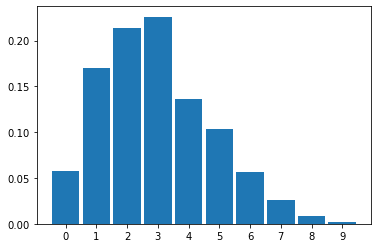

In [5]:
d_values = stats.poisson(3).rvs(500)
az.plot_dist(d_values);

A continuous distribution represents variables taking uncountable number of values. Some examples of continuous random variables are, the temperature during summer, blood pressure of a patience, the time needed to finish a task, etc. By default ArviZ use a kernel density estimation (KDE) to represent continuous distributions.

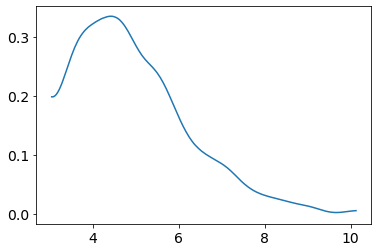

In [6]:
c_values = stats.gamma(2, 3).rvs(500)
az.plot_dist(c_values);

A kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable.

Conceptually you place a _kernel function_ like a gaussian _on top_ of a data-point, then you sum all the gaussians, generally evaluated over a grid and not over the data-points. Results are normalized so the total area under the curve is one.

The following block of code shows a very simple example of a KDE.

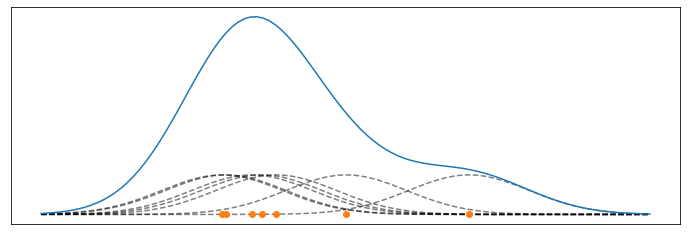

In [7]:
_, ax = plt.subplots(figsize=(12, 4))
bw = 0.4
np.random.seed(19)
datapoints = 7
y = np.random.normal(7, size=datapoints)
x = np.linspace(y.min() - bw * 3, y.max() + bw * 3, 100)
kernels = np.transpose([stats.norm.pdf(x, i, bw) for i in y])
kernels *= 1/datapoints  # normalize the results
ax.plot(x, kernels, 'k--', alpha=0.5)
ax.plot(y, np.zeros(len(y)), 'C1o')
ax.plot(x, kernels.sum(1))

ax.set_xticks([])
ax.set_yticks([]);

Compared to other KDEs in the Python ecosystem. The KDE implemented in ArviZ takes care of the boundaries of a distribution. Basically, ArviZ will assign a density of zero to any point outside the range of the data. Another nice feature of ArviZ's KDE is its the method used to estimate the _bandwith_, this method works pretty well for a wide range of distributions including multimodal ones. The following plot compares the KDEs for ArviZ (on the left) and SciPy (on the right). The blue line is the theoretical distribution and the orange ones are the kernel density estimations.

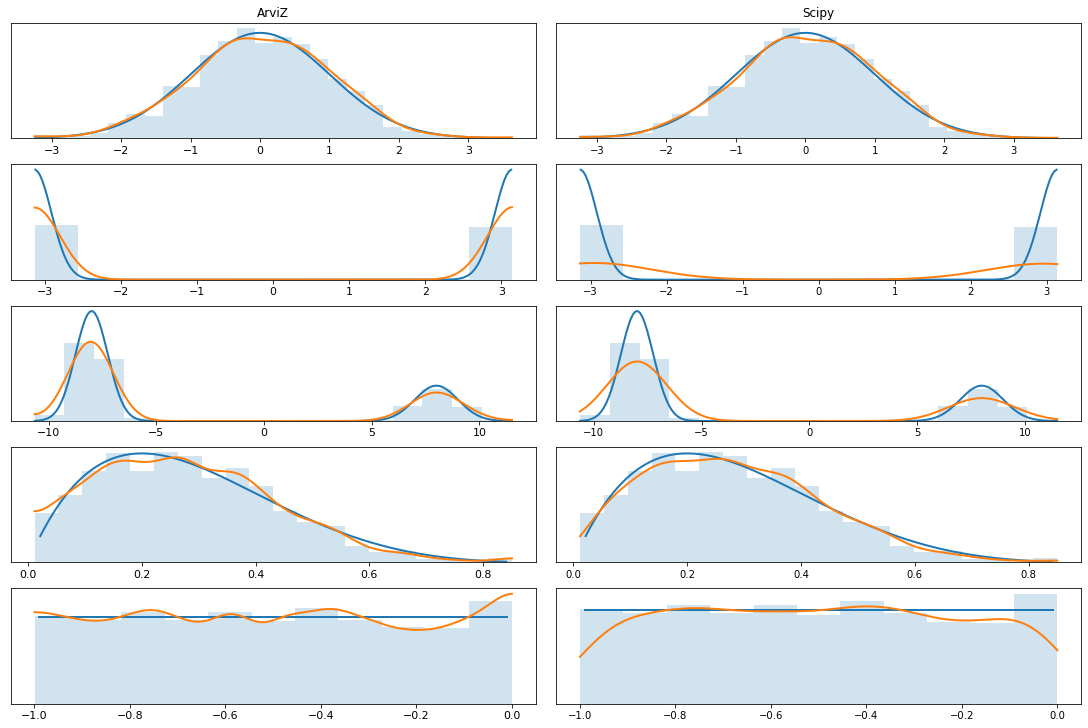

In [8]:
def scipykdeplot(data, ax, **kwargs):
    x = np.linspace(data.min(), data.max(), len(data))
    kde = stats.gaussian_kde(data)
    density = kde.evaluate(x)
    ax.plot(x, density, **kwargs)

size = 1000
bw = 4.5 # ArviZ's default value
_, ax = plt.subplots(5, 2, figsize=(15, 10), constrained_layout=True)

a_dist = stats.vonmises(loc=np.pi, kappa=20)
b_dist = stats.beta(a=2, b=5)
c_dist = [stats.norm(-8, 0.75), stats.norm(8, 1)]
d_dist = stats.norm(0, 1)
e_dist = stats.uniform(-1, 1)
a = a_dist.rvs(size)
a = np.arctan2(np.sin(a), np.cos(a))
b = b_dist.rvs(size)
c = np.concatenate((c_dist[0].rvs(7000), c_dist[1].rvs(3000)))
d = d_dist.rvs(size)
e = e_dist.rvs(size)


ax[0, 0].set_title('ArviZ')
ax[0, 1].set_title('Scipy')

for idx, (i, dist) in enumerate(zip([d, a, c, b, e], [d_dist, a_dist, c_dist, b_dist,  e_dist] )):
    x = np.linspace(i.min()+0.01, i.max()-0.01, 200)
    if idx == 2:
        x_dist = np.concatenate((dist[0].pdf(x[:100]) * 0.7, dist[1].pdf(x[100:]) * 0.3))
    else:
        x_dist = dist.pdf(x)

    ax[idx, 0].plot(x, x_dist, 'C0', lw=2) 
    az.plot_kde(i, ax=ax[idx, 0], bw=bw, textsize=11, plot_kwargs={'color':'C1', 'linewidth':2})
    ax[idx, 0].set_yticks([])
    ax[idx, 0].hist(i, bins='auto', alpha=0.2, density=True)

    ax[idx, 1].plot(x, x_dist, 'C0', lw=2) 
    scipykdeplot(i, ax=ax[idx, 1], color='C1', lw=2)
    ax[idx, 1].set_yticks([])
    ax[idx, 1].hist(i, bins='auto', alpha=0.2, density=True)